In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


In [22]:
df = pd.read_csv("../data/processed/clean_dataset.csv")

print("Columnas del dataset:\n", df.columns, "\n")
df.head()


Columnas del dataset:
 Index(['flight', 'payload', 'orbit', 'site', 'gridfins', 'reused', 'legs',
       'success'],
      dtype='object') 



,flight,payload,orbit,site,gridfins,reused,legs,success
0,6,6500.0,LEO,CCSFS SLC 40,False,False,False,0
1,7,6500.0,LEO,CCSFS SLC 40,False,False,False,0
2,8,525.0,LEO,CCSFS SLC 40,False,False,False,0
3,9,400.0,ISS,CCSFS SLC 40,False,False,False,0
4,10,677.0,ISS,CCSFS SLC 40,False,False,False,0


In [23]:
# payload → imputar con mediana
df["payload"] = df["payload"].fillna(df["payload"].median())

# booleanas → imputar con False y convertir a bool
df[["gridfins", "reused", "legs"]] = (
    df[["gridfins", "reused", "legs"]].fillna(False).astype(bool)
)

# categóricas → imputar con "Unknown"
df["orbit"] = df["orbit"].fillna("Unknown").replace("", "Unknown")
df["site"]  = df["site"].fillna("Unknown").replace("", "Unknown")

# Verificación
print("Valores únicos en orbit:", df["orbit"].unique())
print("Valores únicos en site:", df["site"].unique())


Valores únicos en orbit: ['LEO' 'ISS' 'PO' 'GTO' 'ES-L1' 'SSO' 'HEO' 'MEO' 'VLEO' 'SO' 'GEO'
 'Unknown' 'TLI']
Valores únicos en site: ['CCSFS SLC 40' 'VAFB SLC 4E' 'KSC LC 39A']


In [24]:
numeric_features = ["payload"]
categorical_features = ["orbit", "site"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), categorical_features)
    ]
)


In [25]:
X = df.drop("success", axis=1)
y = df["success"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Shape train:", X_train.shape, "Shape test:", X_test.shape)


Shape train: (156, 7) Shape test: (39, 7)


In [ ]:
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, class_weight="balanced"))
])


clf.fit(X_train, y_train)

print("Accuracy en train:", clf.score(X_train, y_train))
print("Accuracy en test:", clf.score(X_test, y_test))


Accuracy en train: 0.7884615384615384
Accuracy en test: 0.6923076923076923


In [27]:
print("Columnas generadas por el preprocessor:")
print(preprocessor.get_feature_names_out())


Columnas generadas por el preprocessor:
['num__payload' 'cat__orbit_ES-L1' 'cat__orbit_GEO' 'cat__orbit_GTO'
 'cat__orbit_HEO' 'cat__orbit_ISS' 'cat__orbit_LEO' 'cat__orbit_MEO'
 'cat__orbit_PO' 'cat__orbit_SO' 'cat__orbit_SSO' 'cat__orbit_Unknown'
 'cat__orbit_VLEO' 'cat__site_CCSFS SLC 40' 'cat__site_KSC LC 39A'
 'cat__site_VAFB SLC 4E']


Matriz de confusión:
 [[ 4  7]
 [ 5 23]]


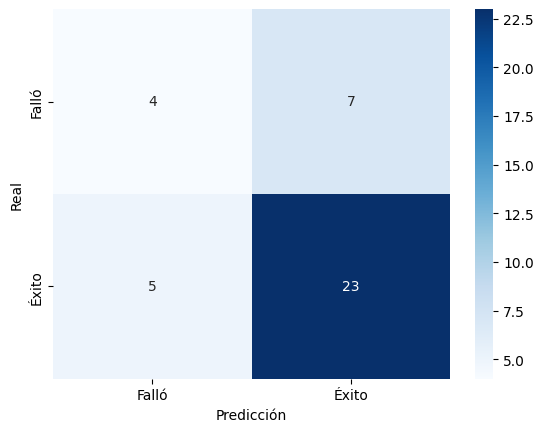

Reporte de clasificación:
              precision    recall  f1-score   support

       Falló       0.44      0.36      0.40        11
       Éxito       0.77      0.82      0.79        28

    accuracy                           0.69        39
   macro avg       0.61      0.59      0.60        39
weighted avg       0.68      0.69      0.68        39



In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Predicciones en test
y_pred = clf.predict(X_test)

# 2. Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:\n", cm)

# Visualización con heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Falló", "Éxito"],
            yticklabels=["Falló", "Éxito"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# 3. Reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=["Falló", "Éxito"]))
